In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from scipy.signal import find_peaks

#read graph from txt file
def readGraphFrom(file):
    G = nx.read_edgelist(file, create_using=nx.Graph(), nodetype=str, data=(('og_weight', float),))
    return G

def _partialEdgeBetweenness(G):
    #create graph to store partial edge betweenness
    NG = G.copy()
    #choose each node as root once
    for root in G:
        #create ShortestPathGraph
        SPG = nx.Graph()
        #calculate shotest path from each node to root and add edges to SPG
        for vertex in G:
            for shortest_path in nx.all_shortest_paths(G, source=vertex, target=root, weight='og_weight'):
                SPG.add_path(shortest_path)
        
        #copy distances from original graph to shortest path graph
        for edge in SPG.edges:
            SPG.edges[edge]['og_weight'] = G.edges[edge]['og_weight']
                    
        #calculate distance and weight for each node in SPG
        max_distance = 0
        for node in SPG:
            if node == root:
                SPG.nodes[node]['distance'] = 0
                SPG.nodes[node]['weight'] = 1
            else:
                distance = nx.shortest_path_length(SPG, source=root, target=node, weight='og_weight')
                #compute maximal distance from root (needed in later steps)
                if distance > max_distance:
                    max_distance = distance
                SPG.nodes[node]['distance'] = distance
                SPG.nodes[node]['weight'] = len(list(nx.all_shortest_paths(SPG, source=root, target=node, weight='og_weight')))
                
        #calculate partial betweenness scores for leaf edges
        for leaf in SPG:
            if SPG.nodes[leaf]['distance'] == max_distance:
                for node1, node2 in SPG.edges(leaf):
                    if node1 == leaf:
                        neighbor = node2
                    else:
                        neighbor = node1
                    SPG.edges[node1, node2][root] = SPG.nodes[neighbor]['weight']/SPG.nodes[leaf]['weight']
                    NG.edges[node1, node2][root] = SPG.nodes[neighbor]['weight']/SPG.nodes[leaf]['weight']
        
        #calculate partial betweenness scores for all other edges by decreasing maximal distance in each iteration
        while max_distance > 1:
            max_distance = max_distance-1
            for node in SPG:
                #only look at nodes at the current distance level
                if SPG.nodes[node]['distance'] == max_distance:
                    for node1, node2 in SPG.edges(node):
                        if node1 == node:
                            neighborUP = node2
                        else:
                            neighborUP = node1
                        if SPG.nodes[neighborUP]['distance'] <= max_distance - 1:
                            sum_of_scores = 0
                            for node11, node22 in SPG.edges(node):
                                if node11 == node:
                                    neighborDOWN = node22
                                else:
                                    neighborDOWN = node11
                                if SPG.nodes[neighborDOWN]['distance'] >= max_distance + 1:
                                    sum_of_scores = sum_of_scores + SPG.edges[neighborDOWN, node][root]
                            #set score for edge from current distance level to one level above (root is at top)
                            SPG.edges[node, neighborUP][root] = (1 + sum_of_scores)*SPG.nodes[neighborUP]['weight']/SPG.nodes[node]['weight']
                            NG.edges[node, neighborUP][root] = (1 + sum_of_scores)*SPG.nodes[neighborUP]['weight']/SPG.nodes[node]['weight']
                            
    return NG

#calculate edge betweenness for graph
def edgeBetweenness(G, node1, node2):
    NG = G.copy()
    
    for component in nx.connected_component_subgraphs(NG):
        #recalculate betweenness scores for graph components that contain at least one of the nodes from the last
        #removed edge
        if component.has_node(node1) or component.has_node(node2) or (node1 == 0 and node2 == 0):
            SPG = _partialEdgeBetweenness(component)
            
            for edge in SPG.edges:
                SPG.edges[edge]['weight'] = 0
                for root in SPG:
                    if root in SPG.edges[edge]:
                        SPG.edges[edge]['weight'] = SPG.edges[edge]['weight'] + SPG.edges[edge][root]
                        
            #copy final scores to new graph
            for edge in SPG.edges:
                NG.edges[edge]['weight'] = SPG.edges[edge]['weight']

    return NG

#determine edge with maximal betweenness score
def maxScoreEdge(G):
    maxScore = 0.0
    for edge in G.edges:
        if maxScore < G.edges[edge]['weight']:
            maxScore = G.edges[edge]['weight']
            edgeRemove = edge
    return edgeRemove

#remove edge from graph
def removeEdge(edge, G):
    G.remove_edge(edge[0], edge[1])
    return G

In [2]:
G = readGraphFrom("graph.txt")
#G = nx.karate_club_graph()

for edge in G.edges:
    G.edges[edge]['weight'] = 0
    #G.edges[edge]['og_weight'] = 1

In [3]:
Graphs = [G]
Mod = [nx.algorithms.community.modularity(G, list(nx.connected_components(G)), weight='og_weight')]

num_iter = len(G.edges)
e = (0, 0)
NG = G.copy()

#iterate as many times as there are edges in the graph
while num_iter > 0:
    #just that we can see progress of algorithm
    print("Remaining Edges: ", num_iter)
    num_iter = num_iter - 1
    #calculate edge betweenness and store values in new graph 
    NG = edgeBetweenness(NG, e[0], e[1])
    e = maxScoreEdge(NG)
    removeEdge(e, NG)
    
    #add graph and modularity to list
    Graphs.append(NG)
    Mod.append(nx.algorithms.community.modularity(G, list(nx.connected_components(NG)), weight='og_weight'))

Remaining Edges:  101
Remaining Edges:  100
Remaining Edges:  99
Remaining Edges:  98
Remaining Edges:  97
Remaining Edges:  96
Remaining Edges:  95
Remaining Edges:  94
Remaining Edges:  93
Remaining Edges:  92
Remaining Edges:  91
Remaining Edges:  90
Remaining Edges:  89
Remaining Edges:  88
Remaining Edges:  87
Remaining Edges:  86
Remaining Edges:  85
Remaining Edges:  84
Remaining Edges:  83
Remaining Edges:  82
Remaining Edges:  81
Remaining Edges:  80
Remaining Edges:  79
Remaining Edges:  78
Remaining Edges:  77
Remaining Edges:  76
Remaining Edges:  75
Remaining Edges:  74
Remaining Edges:  73
Remaining Edges:  72
Remaining Edges:  71
Remaining Edges:  70
Remaining Edges:  69
Remaining Edges:  68
Remaining Edges:  67
Remaining Edges:  66
Remaining Edges:  65
Remaining Edges:  64
Remaining Edges:  63
Remaining Edges:  62
Remaining Edges:  61
Remaining Edges:  60
Remaining Edges:  59
Remaining Edges:  58
Remaining Edges:  57
Remaining Edges:  56
Remaining Edges:  55
Remaining E

In [4]:
#for g in Graphs:
#    print("Components:")
#    print(list(nx.connected_components(g)))
#    print(g.edges)
               
#for mod in Mod:
#    print("Modularity:")
#    print(mod)

Communities with local maximal modularity:
Number of removed edges:  1
Modularity:
0.9641701793941746
Communities:
[{'0616fa4237834cc9', 'e1bc80714154a664', '99bc306b21393623'}, {'7ae662b2d6463366', '07abd570ccfc74b5'}, {'9f637bdf514eb5f0', '1383960c265ca5e0', 'd60c5b1005d1b586', '2b20b7ec37c361e4'}, {'14b694e613b6de34', 'e8f282abc97ca910', '630b86591457c9aa', '71bfc315845a28b9'}, {'fa3f3886eedf5a08', '2360cc814d591ad5', '14d3d3c3066142dc'}, {'ba6be081fd0271f2', '1a74f296ff5f5b6c'}, {'8dfea3396c3ad262', '1cc3c636b852dd3a', '48a86db8e2370425', 'b12a133e828edaa6', '2102d1f1238117f5'}, {'7f32e99a32fc1c1c'}, {'22878bb7c8e36cee', 'fd8aab26d9d60fa9', '3e14755be8fb6d2b', '04564634a13cfe18'}, {'3ca24acde1ab5fa4', '440390633883f4fd', 'f9f9041190cfd765'}, {'49093a8a0d960372', '967e4c8359f6b469', 'f1024681667faf5e', 'bb35b05faeea2cae'}, {'4b7ef2c4496de7fd', '23ce5e9f63427eab', '1db94c57065030b9', 'ef13474387b8e7b8'}, {'4d307691c4e1df21', 'efa2221657dfab68'}, {'4e9116f6ccbb0ef9', '1960b3160b969699

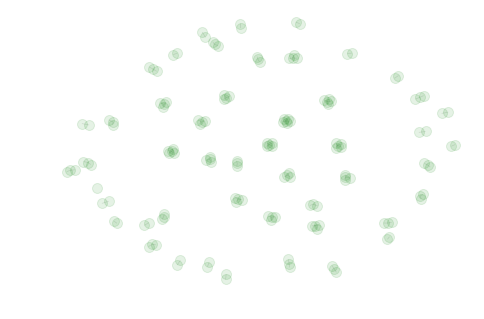

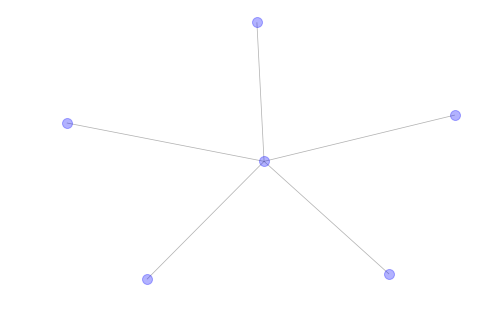

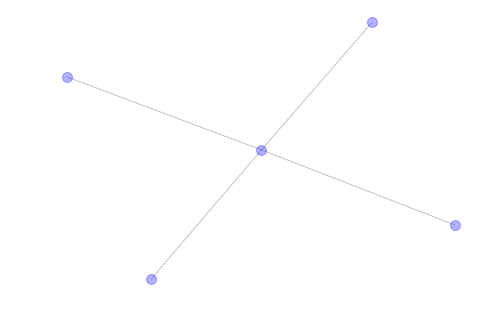

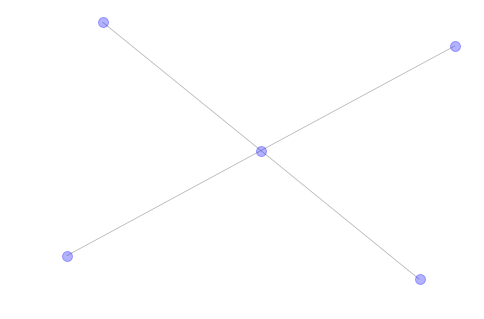

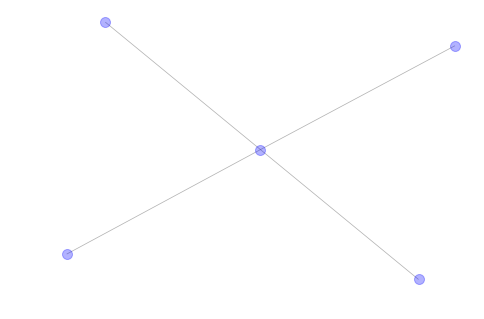

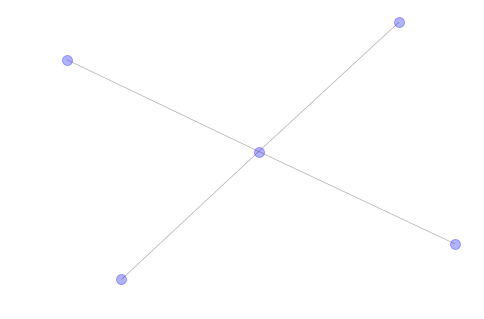

In [7]:
print("Communities with local maximal modularity:")

#find local maxima in modularity array
index_max_mod_np, _ = find_peaks(Mod)
index_max_mod = index_max_mod_np.tolist()

if not index_max_mod:
#    index_max_mod.append(0)
    index_max_mod.append(1)

options = {'node_color': 'green', 'node_size': 100, 'width': 0.75, 'alpha': 0.1}
    
#print modularity and communities for local maxima
for i in index_max_mod:
    print("Number of removed edges: ", i)
    print("Modularity:")
    print(Mod[i])
    print("Communities:")
    print(list(nx.connected_components(Graphs[i])))
    
    #write graph to output file
    outputfile = "output10secstep" + str(i) + ".txt"
    nx.write_edgelist(Graphs[i], outputfile, data=['og_weight'])

    #draw graph
    nx.draw_spring(Graphs[i], **options)
    plt.savefig("graph.pdf")
    plt.show()
    
    options = {'node_color': 'blue', 'node_size': 100, 'width': 0.75, 'alpha': 0.3}
    
    giant = sorted(nx.connected_component_subgraphs(Graphs[i]), key=len, reverse=True)
    giant_components = 5
    #G = giant[0]
    
    if len(giant) < giant_components:
        giant_components = len(giant)
    
    #draw largest graph components
    i = 0
    while i < giant_components:
        nx.draw_spring(giant[i], **options)
        filename = "giant" + str(i) + ".pdf"
        plt.savefig(filename)
        plt.show()
        i = i+1
    

In [6]:
#print size of components
for i in index_max_mod:
    result = list(sorted(nx.connected_components(Graphs[i]), key=len, reverse=True))
    print("Size of components: ")
    for comp in result:
        print(len(comp))

Size of components: 
6
5
5
5
5
4
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
